# ECMWF Storm Data Processing

This notebook demos how to use the functions in `src/ocha_lens/datasources/ecmwf_storm.py`

In [1]:
from datetime import datetime

import geopandas as gpd
from shapely.geometry import LineString

import ocha_lens as lens

Access the `cxml` datasets saved to Azure blob and store as a dataframe. We'll get the forecasts in March 2019 (cyclone Idai).

In [3]:
df = lens.ecmwf_storm.load_hindcasts(
    start_date=datetime(2019, 3, 1),
    end_date=datetime(2019, 3, 25),
    use_cache=False,
    skip_if_missing=False,
    stage="local",
)

Processing for 2019-03-01 00:00:00...
Processing for 2019-03-01 12:00:00...
Processing for 2019-03-02 00:00:00...
Processing for 2019-03-02 12:00:00...
Processing for 2019-03-03 00:00:00...
Processing for 2019-03-03 12:00:00...
Processing for 2019-03-04 00:00:00...
Processing for 2019-03-04 12:00:00...
Processing for 2019-03-05 00:00:00...
Processing for 2019-03-05 12:00:00...
Processing for 2019-03-06 00:00:00...
Processing for 2019-03-06 12:00:00...
Processing for 2019-03-07 00:00:00...
Processing for 2019-03-07 12:00:00...
Processing for 2019-03-08 00:00:00...
Processing for 2019-03-08 12:00:00...
Processing for 2019-03-09 00:00:00...
Processing for 2019-03-09 12:00:00...
Processing for 2019-03-10 00:00:00...
Processing for 2019-03-10 12:00:00...
Processing for 2019-03-11 00:00:00...
Processing for 2019-03-11 12:00:00...
Processing for 2019-03-12 00:00:00...
Processing for 2019-03-12 12:00:00...
Processing for 2019-03-13 00:00:00...
Processing for 2019-03-13 12:00:00...
Processing f

Process this dataframe into the `storms` and `forecast_track` standards

In [4]:
df_storms, gdf_forecasts = lens.ecmwf_storm.get_storms_and_tracks(df)

In [7]:
df_storms.head(3)

,name,number,storm_id,provider,season,basin
72,Veronica,21,Veronica_Southwest Pacific_2019,ecmf,2019,Southwest Pacific
71,Joaninha,13,Joaninha_Southwest Pacific_2019,ecmf,2019,Southwest Pacific
65,Trevor,20,Trevor_Southwest Pacific_2019,ecmf,2019,Southwest Pacific


In [8]:
gdf_forecasts.head(3)

,issued_time,id,basin,leadtime,valid_time,pressure,wind_speed,season,storm_id,point_id,geometry
0,2019-03-01 00:00:00+00:00,2019030100_252S_1781W,Southwest Pacific,0,2019-03-01 00:00:00+00:00,962,39.1,2019.0,Pola_Southwest Pacific_2019,0efde7f6-f9df-4b14-a0a7-6800b228317a,POINT (-178.5 -26.3)
1,2019-03-01 00:00:00+00:00,2019030100_252S_1781W,Southwest Pacific,6,2019-03-01 06:00:00+00:00,973,29.8,2019.0,Pola_Southwest Pacific_2019,3dbdf349-f810-4736-9661-cc0d2936e792,POINT (-178.3 -27.2)
2,2019-03-01 00:00:00+00:00,2019030100_252S_1781W,Southwest Pacific,12,2019-03-01 12:00:00+00:00,980,30.9,2019.0,Pola_Southwest Pacific_2019,cf856601-8776-42ff-8134-481fb341dd87,POINT (-177.9 -28)


A very basic plot of the forecast tracks that we've defined as a storm.

<Axes: >

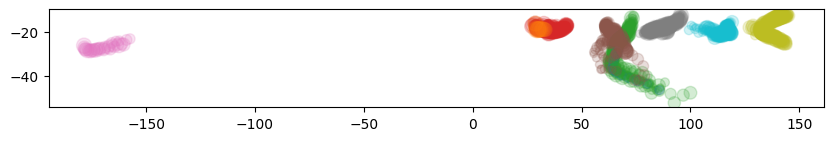

In [9]:
gdf_forecasts.plot(
    column="storm_id",
    markersize=df["wind_speed"] * 3,
    legend=False,
    figsize=(10, 8),
    alpha=0.2,
)

And do a simple transformation of all points into tracks. We can see the IDs are unique as we'd expect here...

/var/folders/rv/xmclt0vn5y7cqt46s5xq3h080000gn/T/ipykernel_94539/1925757945.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: LineString([(pt.x, pt.y) for pt in x.geometry]))


<Axes: >

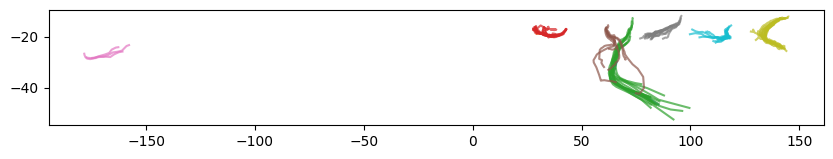

In [10]:
tracks = (
    gdf_forecasts.sort_values("valid_time")
    .groupby(["storm_id", "id"])
    .apply(lambda x: LineString([(pt.x, pt.y) for pt in x.geometry]))
    .reset_index(name="geometry")
)


tracks_gdf = gpd.GeoDataFrame(tracks, crs=gdf_forecasts.crs)
track_attrs = gdf_forecasts.groupby("storm_id").first().reset_index()
tracks_gdf = tracks_gdf.merge(
    track_attrs[["storm_id", "basin"]], on="storm_id"
)

tracks_gdf.plot(
    column="storm_id",
    legend=False,
    alpha=0.7,
    figsize=(10, 10),
)

In [12]:
gdf_forecasts.to_file("test_2019.shp")

/var/folders/rv/xmclt0vn5y7cqt46s5xq3h080000gn/T/ipykernel_94539/1920231227.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_forecasts.to_file("test_2019.shp")
/Users/hannahker/Desktop/ocha-lens/venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'issued_time' to 'issued_tim'
  ogr_write(
/Users/hannahker/Desktop/ocha-lens/venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field issued_tim create as date field, though DateTime requested.
  ogr_write(
/Users/hannahker/Desktop/ocha-lens/venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field valid_time create as date field, though DateTime requested.
  ogr_write(
